In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn import metrics
import warnings
warnings.simplefilter(action='ignore')

In [2]:
TEST_SIZE = 20000 # 10K matches

In [3]:
df_org = pd.read_csv('data.csv', index_col ='match_timestamp', parse_dates = True)

In [4]:
df_org.head(2)

,player_id,match_id,deck_id,score
match_timestamp,,,,
2024-01-23 09:28:10.022,1bc8e720-a051-4ed5-8a94-ae58512bdb2f,4b4c7a4d-4f5c-43cf-bf48-ae0f17ee5a2b,708a7c88-4ee1-4d96-beff-77adeb57d258,684
2024-03-17 22:48:17.574,617224e3-9185-47e1-8ba5-337d2881fc6a,9577f089-bd3d-404f-8efb-9dc0a02f05ad,3f444927-d9d8-4014-9d9b-da36ba4bb5f6,1455


In [5]:
df_org['score'].describe()

count    220904.000000
mean       4937.325499
std        3411.071083
min         400.000000
25%        1720.000000
50%        3235.000000
75%        8349.000000
max       11886.000000
Name: score, dtype: float64

In [7]:
# df_player = df.groupby('player_id')['score'].apply(lambda df_player: df_player.rolling(roll_step).mean().iloc[roll_step:]) 
roll_step = 10
df_player = df_org.groupby('player_id')['score'].apply(lambda df_player: df_player.sort_index().rolling(roll_step).mean().iloc[roll_step:]) 

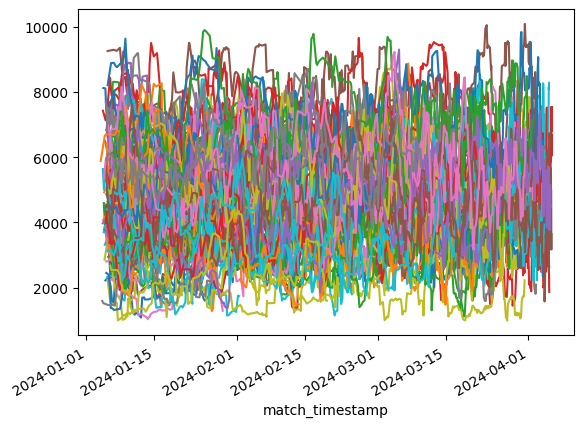

In [8]:
player_ids = df_player.index.get_level_values('player_id').unique()

for player in player_ids[:100]:
    df_player.xs(player, level='player_id').plot()

plt.show()

Doesn't seem that the players has an upward trend (improve their skills) over time, or any trend. 
Possible reasons:
* It's only a superficial examination
* It's likely many of these players aren't beginners to start with, and already made their main improvements in the first weeks/months.


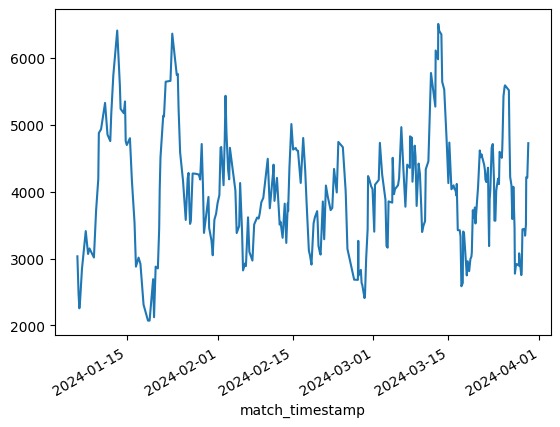

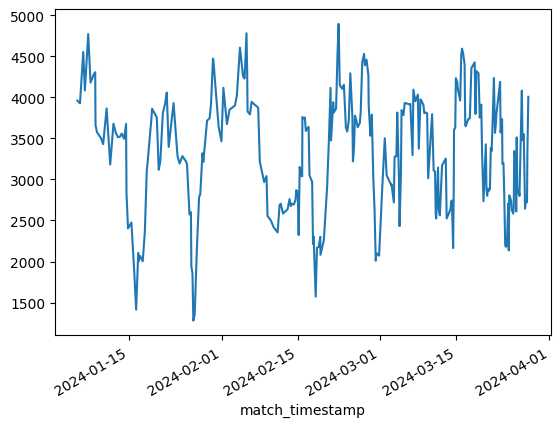

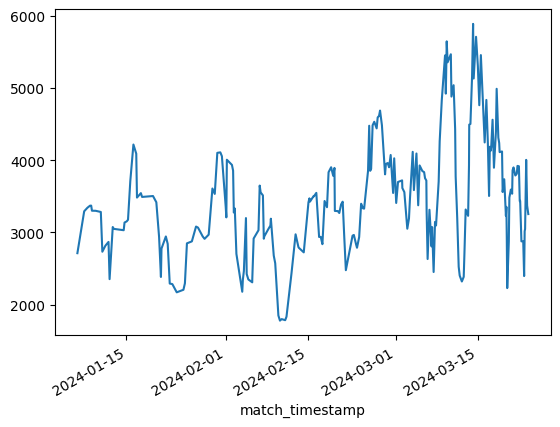

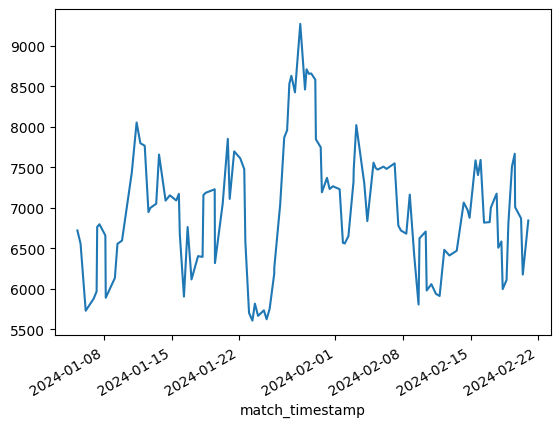

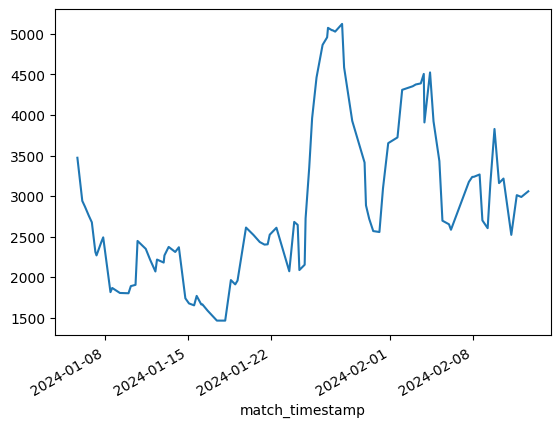

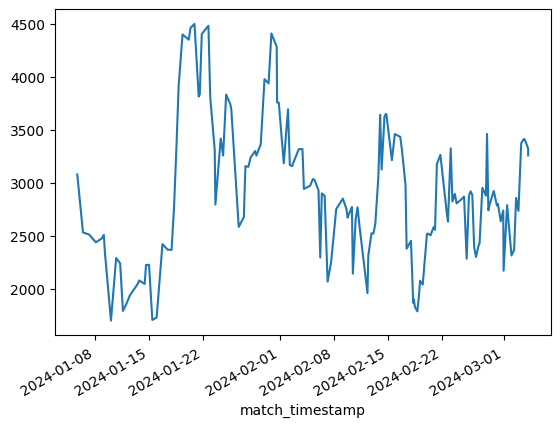

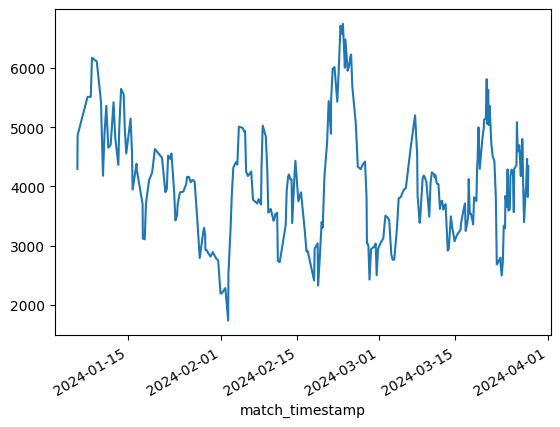

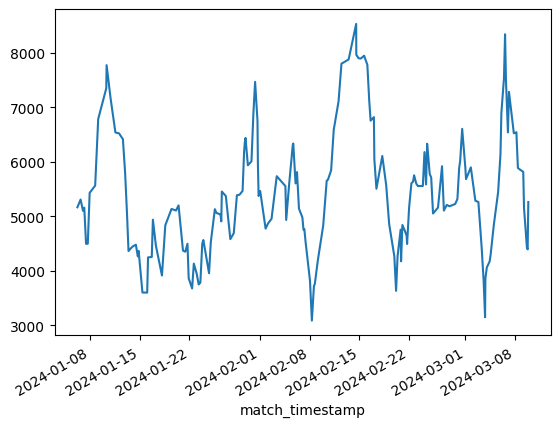

In [9]:
player_ids = df_player.index.get_level_values('player_id').unique()

for player in player_ids[:8]:
    df_player.xs(player, level='player_id').plot()
    plt.show()

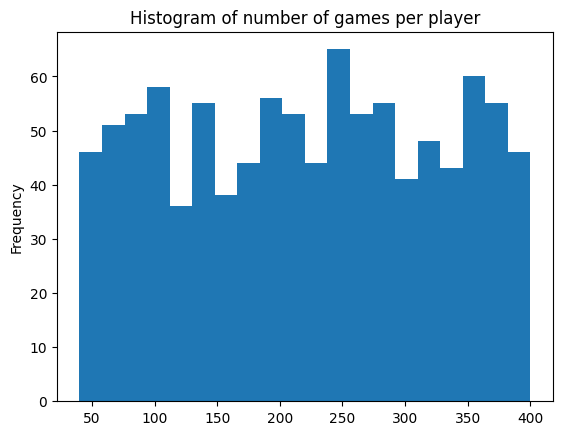

In [11]:
df_org.groupby('player_id')['score'].count().plot.hist(bins=20, title='Histogram of number of games per player');

In [13]:
df_org.groupby('player_id')['deck_id'].count() == df_org.groupby('player_id')['deck_id'].nunique()

player_id
0032274f-d2c1-478c-9f35-7d2c391355ee    False
00a26687-7af9-4266-9635-e02cd802672a    False
0122a6aa-4338-4e1d-a3ca-12f246948c12    False
0143e265-6f7e-4428-b77c-7e8d9f26da0d    False
0161780f-b608-42ef-9f55-564b49510f02    False
                                        ...  
fd7ad46b-0c59-4355-9879-27bc35fdc53f    False
fee129ee-8caf-43ef-8c2f-b55a49d845ca    False
ff760b96-a7ef-44cc-a5af-dfdfb17a1980    False
ffa3cbe9-eb4e-4902-928c-2698a1397746    False
ffbabf4c-7027-42a5-81d0-b90bca2cd0bc    False
Name: deck_id, Length: 1000, dtype: bool

Players can definately the same deck several times

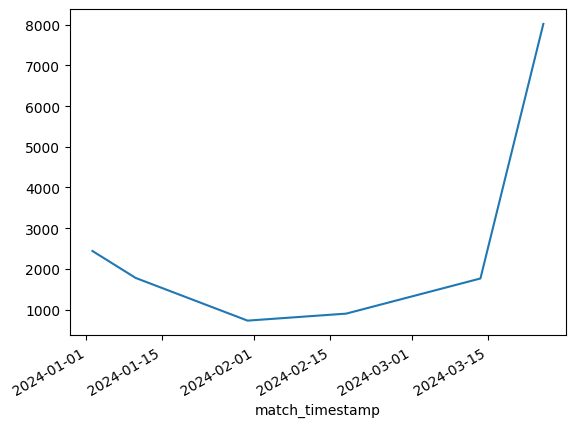

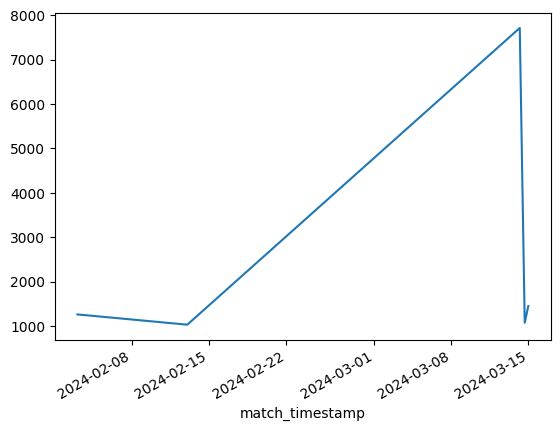

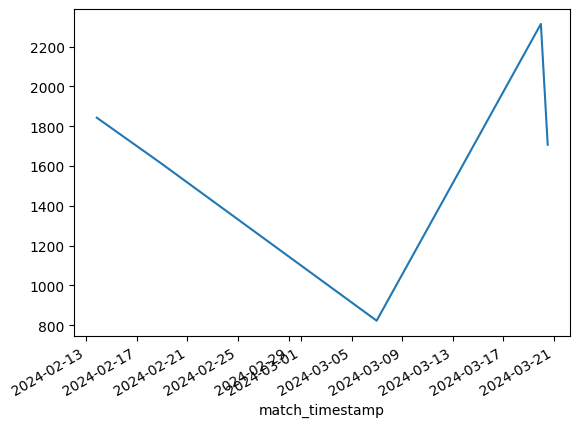

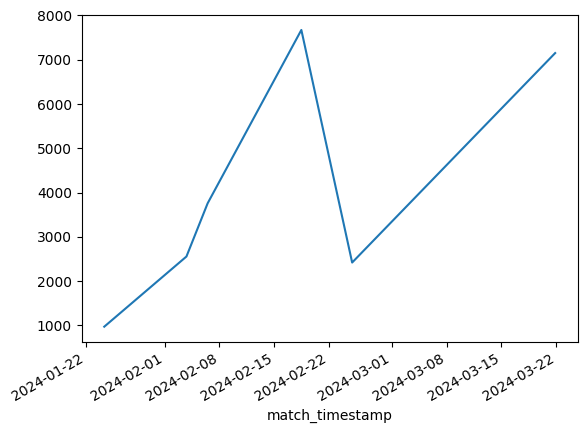

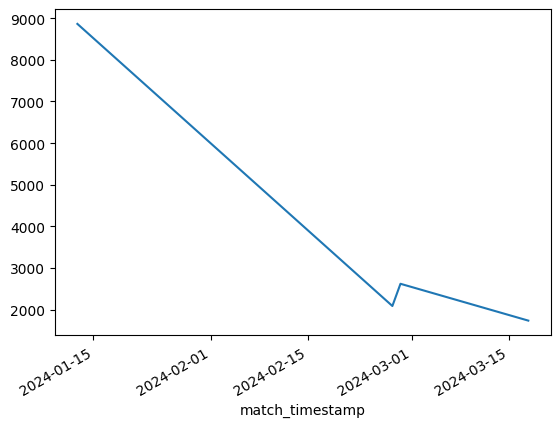

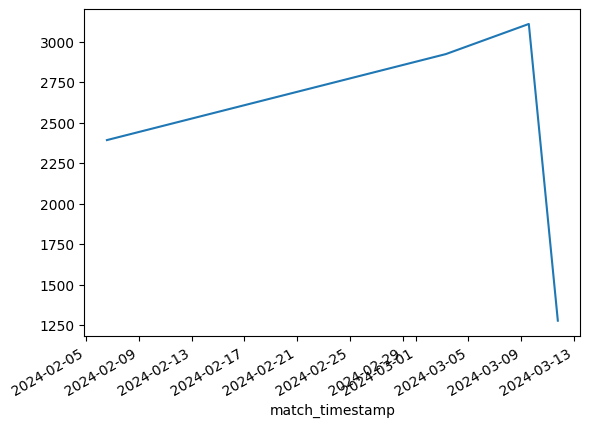

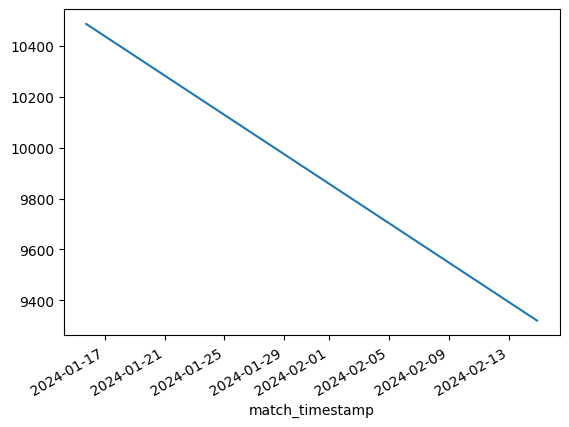

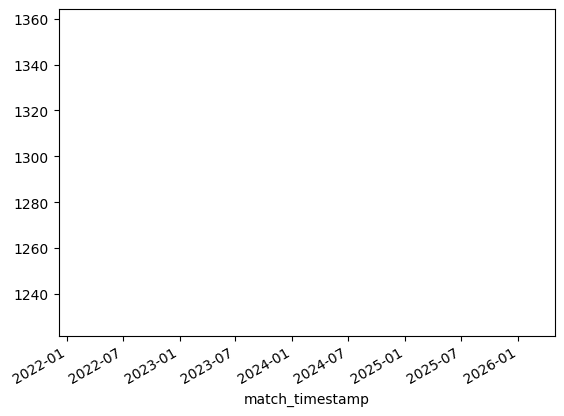

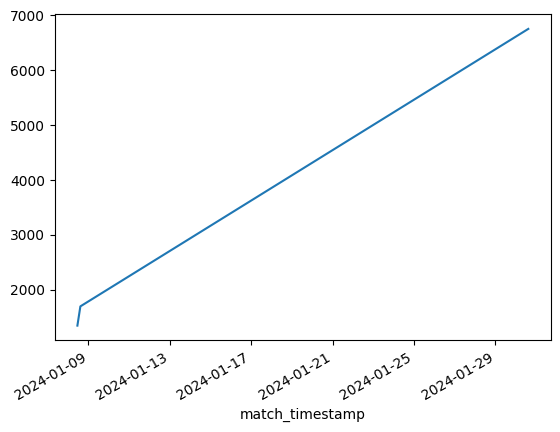

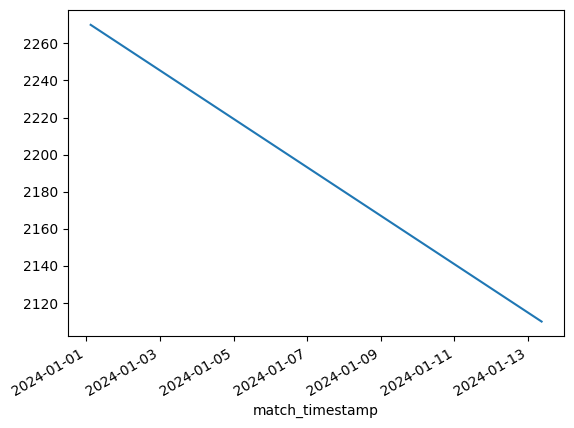

In [15]:
df_player = df_org.groupby(['player_id', 'deck_id'])['score'].apply(lambda df_player: df_player.sort_index()) 

roll_step = 10
player_ids = df_player.index.get_level_values('player_id').unique()

for player in player_ids[:5]:
    df_player_i = df_player.xs(player, level='player_id')
    deck_ids = df_player_i.index.get_level_values('deck_id').unique()
    for deck in deck_ids[:2]:
        df_player_i.xs(deck, level='deck_id').plot()
        plt.show()

Doesn't seem that the number of past games in the same deck affects the score. I assume this game is played out different depending on the moves the player chooses to make, for example like chess, and not "static" like, say, sudoku. 

So in first inspection, my concolusions are:
* the players don't get significantly better by time 
* the players don't get significantly better at the same deck by number of games

Of course, those statements aren't certain. In order to prove significance, one has to perform z-test on the correlation of scores over time (in general and by deck) to see if there's an upward trend.

Due to lack of time, I'm going to assume those statement are true and not use time series models for the prediction (like LSTM), but other regression models. I understand it may be a mistake and of course for an actual project my inspection would be way more thourough. To make things simpler, this is my descision for this exercise.

A few challenges in time series modeling that I'm trying to avoid:
1. As noted, there doesn't seem to be change by time and if so, we're not usilizing the method's abilities correctly. But say that our findings aren't significant and there actually is a difference in scores by time.
2. Time series usually needs to be aggregated by frequency, meaning we can't make a prediction per match, but per time step and that's not answering our question - who would win in a match. But I suppose the frequency could be by match, which might raise problems - if the time progress is important than it could be problematic for example if the player took a very long break from playing and it's not given in the data since we're ignoring the time.
3. Needs to decide the sequence length. on the one hand, it would be most informative to have all the history per player in a sequence since even early days show his skills well, however time series sequences typically shouldn't be that long + should be the same length for every example.


So how are we going to predict who'll win?

We're going to predict per player, per deck, the score he's going to get. Then, we'll see which player's score is higher and determine the winner estimation by that. 

The player id and the deck id isn't going to cut it for a prediction, because it has no meaning, we want to catch the actual meaning of a player - how skillful is he? And the actual meaning of a deck - how difficult is it?

To do that, we'll describe the player by statistical analysis of his historic scores. We'll do the same for a deck - statistical analysis of historic scores players got playing that deck.


Now it's time to start building our dataset:

In [16]:
df_org.sort_index(inplace=True)

In [17]:
def create_statistical_df(df:pd.DataFrame, object_str:str) -> pd.DataFrame:
    """ Creates normalized statistical analysis (mean, median, min, max, std) by grouping per object in the dataframe.
        That object could be either player or deck.
        The function returns the data as a dataframe
    """
    df_object = df.groupby(f'{object_str}_id')['score'].agg(
        mean='mean',
        median='median',
        min='min',
        max='max',
        std='std')
        
    df_object.rename(columns={col:f'{object_str}_{col}' for col in df_object.columns}, inplace=True)

    # numerical_columns = df_object.columns[1:] 
    scaler = MinMaxScaler()
    df_object.loc[:] = scaler.fit_transform(df_object.loc[:])
    return df_object, scaler

In [27]:
df_player, scaler_player = create_statistical_df(df_org.iloc[:-TEST_SIZE], 'player')
df_deck, scaler_deck = create_statistical_df(df_org.iloc[:-TEST_SIZE], 'deck')

Let's merge everything into one dataframe.

Notice we calculated the new features only according to the train dataframe, and we'll add those features as is to the whole dataframe, train and test.

In [28]:
df = pd.merge(df_org, df_deck, on='deck_id')
df = pd.merge(df, df_player, on='player_id')

In [91]:
df.head(3)

,player_id,match_id,deck_id,score,deck_mean,deck_median,deck_min,deck_max,deck_std,player_mean,player_median,player_min,player_max,player_std
0,43f9fa86-7ce8-480f-a72e-9a3c615c2628,42c77b58-bcb9-45dc-b4e5-21798746236f,66d829cb-2d75-4c76-81cb-3a2642f0699e,9108,0.307453,0.069603,0.0625,0.661730,0.750321,0.706154,0.824894,0.054348,0.883431,0.926859
1,6ae00ce1-6ec4-424b-a7bf-a9c7bcb431a6,42c77b58-bcb9-45dc-b4e5-21798746236f,66d829cb-2d75-4c76-81cb-3a2642f0699e,8872,0.307453,0.069603,0.0625,0.661730,0.750321,0.553696,0.690990,0.038043,0.867542,0.911487
2,3c46eb1a-2f7a-4cba-8356-ee877c69aa1c,df08cc1b-0c44-483c-a36a-d7543eb30c29,3f444927-d9d8-4014-9d9b-da36ba4bb5f6,2207,0.494214,0.186481,0.0000,0.300078,0.938282,0.228682,0.097241,0.012681,0.404831,0.545469


Let's divide the data to train and test.

Usually should divide to train, validation, test, but we'll keep it simple and divide to train and test only

In [30]:
df_train = df.iloc[:-TEST_SIZE]
df_test = df.iloc[-TEST_SIZE:]

In [36]:
X_columns = [col for col in df.columns if (not 'id' in col) and col != 'score']

X_train = df_train[X_columns].values
y_train = df_train['score'].values

X_test = df_test[X_columns].values
y_test = df_test['score'].values

# let's print the data shapes for sanity check
print('shapes: ', X_train.shape, y_train.shape, X_test.shape, y_test.shape)

shapes:  (200904, 10) (200904,) (20000, 10) (20000,)


Time for building and training the model.
We'll keep the architecture simple.

In [40]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  
    Dropout(0.2),
    Dense(1)  
])

# I added regularization (l2 regularizer and dropout) after I saw there's overfitting. 

opt = Adam(learning_rate=0.005, weight_decay=0.3)
model.compile(optimizer=opt, loss='mean_squared_error')

model_fit = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
6279/6279 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 11451416.0000 - val_loss: 9625684.0000
Epoch 2/20
6279/6279 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 9840644.0000 - val_loss: 9356336.0000
Epoch 3/20
6279/6279 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 9839458.0000 - val_loss: 9496702.0000
Epoch 4/20
6279/6279 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 9840625.0000 - val_loss: 9674768.0000
Epoch 5/20
6279/6279 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 9816412.0000 - val_loss: 9576597.0000
Epoch 6/20
6279/6279 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 9840627.0000 - val_loss: 9310207.0000
Epoch 7/20
6279/6279 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 9789987.0000 - val_loss: 9585918.0000
Epoch 8/20
6279/6279 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 9805219.0000 - val_loss: 9299986.0000
Epoch 9/20
6279/6279 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 9855216.0000 - val_loss: 9336753.0000
Epoch 10/20
6279/6279 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 9777013.0000 - val_loss: 9487832.000

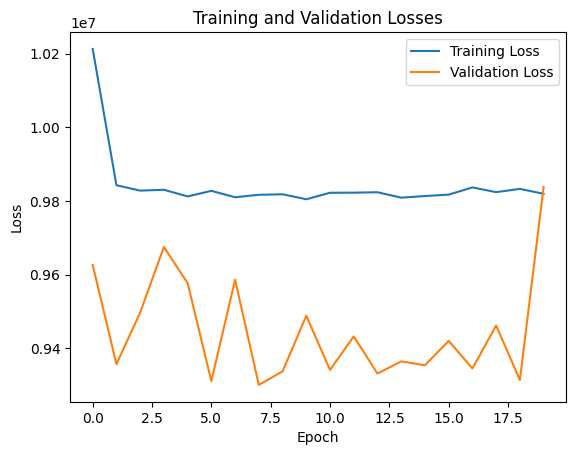

In [41]:
plt.plot(model_fit.history['loss'], label='Training Loss')
plt.plot(model_fit.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [44]:
yhat = model.predict(X_test)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 827us/step


We'll first evaluate the model as a regression task, since it is a regression model.
I chose to look at rmse and compare it (by eye) to the median and mean of the actual target as a refrence and also look and the mean absolute percentage error.

In [45]:
print(f'RMSE: {np.round(metrics.root_mean_squared_error(y_test, yhat),4)}, actual score mean, median: {df_test['score'].mean(), df_test['score'].median()}')
print(f'MAPE: {np.round(metrics.mean_absolute_percentage_error(y_test, yhat),4)}')

RMSE: 3136.5054, actual score mean, median: (4938.899, 3234.5)
MAPE: 1.058


Not great scores. 

The MAPE is over 100% (shouldn't be above even 50% for a fine model) and the RMSE should be very low but it's very close to the median.

Let's evaluate the problem as it was defined - a classification problem. Estimating who won the match, the first player or the second player.

In [46]:
df_test['score_prediction'] = yhat

In [90]:
winner = df_test.groupby('match_id')['score'].idxmax()
winner_prediction = df_test.groupby('match_id')['score_prediction'].idxmax()
outcomes = (winner == winner_prediction).values

accuracy = sum(outcomes)/len(outcomes)
print('Accuracy: ', accuracy)

Accuracy:  0.6676


It should be noted it's not a regular classification problem and we can't evaluate by recall, precision and other customary classification metrics, because there's no significance to order to the two players in a match. They can be swapped, there's no meaning to which is which so you can only estimate if our model was right or wrong per match.

how to improve:
* deck statistics: try only first game per player
* player statistic - weighted by deck difficulty
* use different normalization
* normalize the score
* use time series model, like LSTM


challenges:
* address new players and new decks